In [1]:
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from gtime.forecasting.arima import ARIMA
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import TimeSeriesForecastingModel
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
import matplotlib.pyplot as plt
%matplotlib inline  

## TIme series

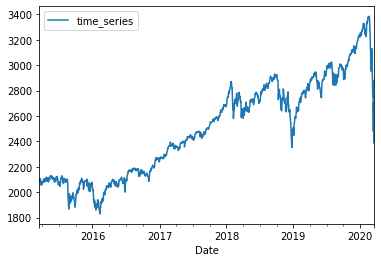

In [2]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv', parse_dates=['Date'])
df_close = df_sp.set_index('Date')['Close']
time_series_preparation = TimeSeriesPreparation()
df_real = time_series_preparation.transform(df_close)

df_real.plot();

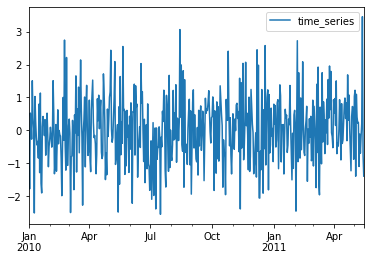

In [3]:
df_white = pd.DataFrame(np.random.standard_normal(500))
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_white = time_series_preparation.transform(df_white)

df_white_train_giotto = df_white.iloc[:500]
df_white_train = df_white.iloc[:400]
df_white_test = df_white.iloc[400:500]
df_white_train_giotto.plot()

In [4]:
def train_test_plot(df_train, df_test, df_pred, train_error, test_error):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    df_train.plot(ax=ax[0])
    df_test.plot(ax=ax[0])
    df_pred.plot(ax=ax[0])
    ax[1].hist(train_error)
    ax[2].hist(test_error)

../gtime/stat_tools/mle_estimate.py:85: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


[-43.71  43.17  -8.97 -63.17] [  7.17 -10.25 -61.63]
Fitted parameters: mu=-0.06, p=[0.35 0.63 0.02 0.15], q=[-0.58  0.11 -0.38]
AR roots abs:[2.36 2.36 1.3  0.93]
MA roots abs:[1.55 1.55 1.1 ]
Train error mean: 0.80, std: 18.02
RMSE: 567495606.43
NormaltestResult(statistic=116.64080943904077, pvalue=4.6964537297105266e-26)


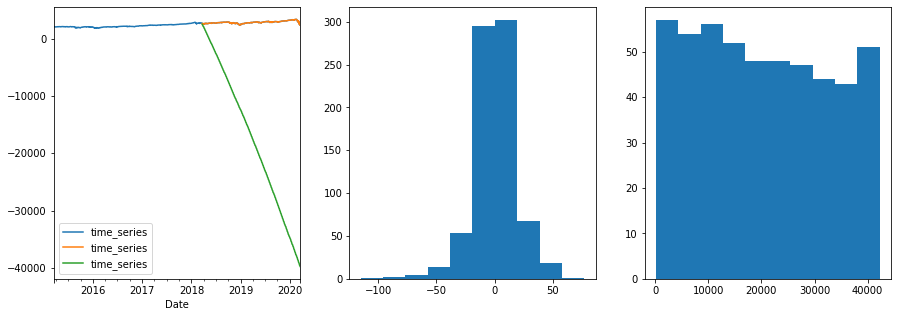

In [16]:
def run_giotto(df, test_size, order, method='css-mle'):
    features = [("s1", Shift(0), make_column_selector()),]
    model = TimeSeriesForecastingModel(features=features, horizon=test_size, model=ARIMA(order, method=method))
    df_train = df
    df_test = df.iloc[-test_size:]
    model.fit(df_train)
    pred_g = model.predict(df_test.iloc[[0]])
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    phi = model.model.params['phi'].values[0]
    theta = model.model.params['theta'].values[0]
    mu = model.model.params['mu'].values[0]
    train_errors = model.model.params['errors'].values[0]
    print(f'Fitted parameters: mu={mu:.2f}, p={phi}, q={theta}')
    print(f'AR roots abs:{np.abs(np.roots(np.r_[-phi[::-1], 1.0]))}')
    print(f'MA roots abs:{np.abs(np.roots(np.r_[theta[::-1], 1.0]))}')
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}')
    print(normaltest(train_errors))
    test_errors = df_test -  y_pred
    train_test_plot(df_train, df_test, y_pred, train_errors, test_errors.values)

    
run_giotto(df_real, 500, (4, 2, 3), 'css')

Fitted parameters: mu=0.01, p=[ 3.41e-02 -1.05e+00 -5.60e-04 -7.45e-02], q=[-1.    1.04 -0.97]
AR roots abs:[1.01 1.01 3.62 3.62]
MA roots abs:[1.03 1.   1.  ]
Train error mean: 0.36, std: 17.55
RMSE: 251233.53
NormaltestResult(statistic=165.42581793152073, pvalue=1.197402206230898e-36)


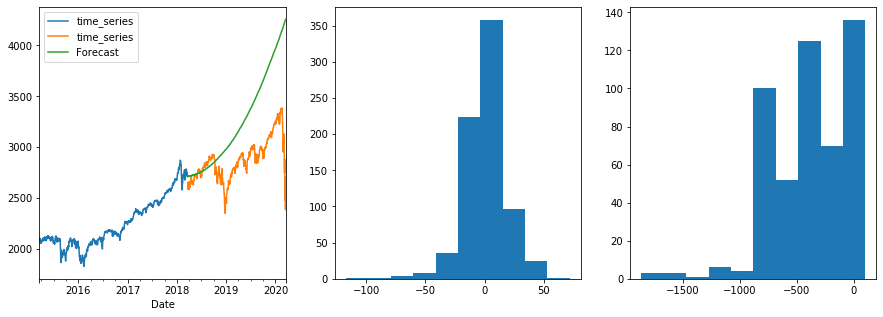

In [15]:
def run_sm(df, test_size, order, method='css-mle'):
    df_train = df.iloc[:-test_size]
    df_test = df.iloc[-test_size:]
    m2 = ARIMA_sm(df_train, order)
    f = m2.fit(method=method)
    y2, _, _ = f.forecast(test_size)
    y_pred = pd.DataFrame(y2, index=df_test.index, columns=['Forecast'])
    
    print(f'Fitted parameters: mu={f.params.const:.2f}, p={f.arparams}, q={f.maparams}')
    print(f'AR roots abs:{np.abs(f.arroots)}')
    print(f'MA roots abs:{np.abs(f.maroots)}')
    train_errors = m2.geterrors(f.params)
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'RMSE: {mean_squared_error(y2, df_test.values):.2f}')
    print(normaltest(train_errors))
    test_errors = df_test.values.flatten() -  y2
    train_test_plot(df_train, df_test, y_pred, train_errors, test_errors)

run_sm(df_real, 500, (4, 2, 3), 'css')

In [7]:
def _forecast_arma(n, phi, theta, x0, eps0):
    len_ar = len(phi)
    len_ma = len(theta)
    x = np.r_[x0, np.zeros(n)]
    eps = np.r_[eps0, np.zeros(n)]
    for i in range(n):
        x[i+1] = np.dot(phi, x[i:i + len_ar]) + np.dot(theta, eps[i:i + len_ma])
    return x[len_ar:]

_forecast_arma(100, [-1], [], [392.98], [])

array([-392.98,  392.98, -392.98,  392.98, -392.98,  392.98, -392.98,
        392.98, -392.98,  392.98, -392.98,  392.98, -392.98,  392.98,
       -392.98,  392.98, -392.98,  392.98, -392.98,  392.98, -392.98,
        392.98, -392.98,  392.98, -392.98,  392.98, -392.98,  392.98,
       -392.98,  392.98, -392.98,  392.98, -392.98,  392.98, -392.98,
        392.98, -392.98,  392.98, -392.98,  392.98, -392.98,  392.98,
       -392.98,  392.98, -392.98,  392.98, -392.98,  392.98, -392.98,
        392.98, -392.98,  392.98, -392.98,  392.98, -392.98,  392.98,
       -392.98,  392.98, -392.98,  392.98, -392.98,  392.98, -392.98,
        392.98, -392.98,  392.98, -392.98,  392.98, -392.98,  392.98,
       -392.98,  392.98, -392.98,  392.98, -392.98,  392.98, -392.98,
        392.98, -392.98,  392.98, -392.98,  392.98, -392.98,  392.98,
       -392.98,  392.98, -392.98,  392.98, -392.98,  392.98, -392.98,
        392.98, -392.98,  392.98, -392.98,  392.98, -392.98,  392.98,
       -392.98,  392